# Paper figure: Case study

In [1]:
from datetime import datetime
from itertools import product
from pathlib import Path
from typing import Any
import seaborn as sns 
import joblib
# import keras
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go
# import streamlit as st
# import tensorflow as tf
import xarray as xr
from sklearn import metrics
# from sklearn.ensemble import RandomForestClassifier

## Get your Constants

In [2]:
PHASE_MAP = {
    0: "clear",
    1: "liquid",
    2: "ice",
    3: "mixed",
    4: "drizzle",
    5: "liq_driz",
    6: "rain",
    7: "snow",
    8: "unknown",
}

In [3]:
BASE_PATH = Path("/home/gold396/thermocldphase/aces/thermocldphase_data/output/nsa6/nsathermocldphaseC1.c1/")
FILE_GLOB = "nsathermocldphaseC1.c1.20210831.000000.nc"
FILE_GLOB = "nsathermocldphaseC1.c1.20210831.000000.nc"
FILE_GLOB = "nsathermocldphaseC1.c1.20210831.000000.nc"
FILE_GLOB = "nsathermocldphaseC1.c1.20210831.000000.nc"


In [4]:
_cblind = sns.color_palette("colorblind")

custom_colors = [
    "white",  # clear (white)
    _cblind[2],  # liquid (dark purple from viridis)
    _cblind[0],  # ice (blue from viridis)
    _cblind[3],  # mixed (greenish-blue from viridis)
    _cblind[9],  # drizzle (light green from viridis)
    _cblind[6],  # liq_driz (yellow from viridis)
    _cblind[8],  # rain (brighter yellow)
    _cblind[5],  # snow (orange-yellow)
    "black",  # unknown (grey)
]

In [5]:
# Construct the full file path
file_path = BASE_PATH / FILE_GLOB

# Open the NetCDF file with xarray
ds = xr.open_dataset(file_path)

# Display the dataset information
# ds

## Figure Code called as functions

In [71]:
def create_matrix(variable_name, axs, ds, PHASE_MAP):
    """
    Create a confusion matrix with accuracy and IoU metrics.
    
    Parameters:
    axs (matplotlib.axes.Axes): The axis to plot the figure on.
    ds (xarray.Dataset): The dataset containing the true and predicted labels.
    PHASE_MAP (dict): Dictionary mapping the phase labels to categories.
    """
    # Convert xarray data to pandas series
    y_true = ds["cloud_phase_mplgr"].to_series()
    y_pred = ds[variable_name].to_series()

    # Remap predictions and ground truth to categorical labels
    y_pred = y_pred.reset_index(drop=True).map(PHASE_MAP).astype("category")
    y_true = y_true.reset_index(drop=True).map(PHASE_MAP).astype("category")
    labels = list(PHASE_MAP.values())

    # Calculate accuracy and mean IoU
    accuracy = metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
    iou = np.mean(metrics.jaccard_score(y_true=y_true, y_pred=y_pred, average=None))

    # Set font size for the plot
    font = {'size': 5}
    plt.rc('font', **font)

    # Generate and plot the confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        labels=labels,
        ax=axs,
        colorbar=False,
        normalize="true"
    )

    # Set title and labels for the plot
    axs.set_title(f"Accuracy={100*accuracy:.3f}%, Mean IoU={iou:.3f}", fontsize=10)
    axs.set_ylabel("Ground Truth", fontsize=14)
    if variable_name == 'rf_1600k_20240514_033147':
        axs.set_xlabel("Model Classification", fontsize=14)
    else:
        axs.set_xlabel("")

    # Rotate x-tick labels and set fontsize using tick_params
    axs.tick_params(axis='x', rotation=45, labelsize=7)
    axs.tick_params(axis='y', labelsize=7)

# Example usage:
# fig, axs = plt.subplots(figsize=(6, 6))
# create_matrix('cnn_20240429_213223',axs, ds, PHASE_MAP)
# plt.show()


In [69]:
def create_timeseries(variable_name, axs, ds, PHASE_MAP, custom_colors):
    """
    Creates a timeseries plot along with a confusion matrix and custom colorbar.
    
    Parameters:
    axs (matplotlib.axes.Axes): The axis to plot the figure on.
    ds (xarray.Dataset): The dataset containing the timeseries data.
    PHASE_MAP (dict): Dictionary mapping the phase labels to categories.
    custom_colors (list): Custom colors to apply to different phases in the timeseries.
    """
    # Extract phase values and labels
    phase_values = list(PHASE_MAP.keys())
    phase_labels = list(PHASE_MAP.values())

    # Define the integer range for levels
    min_val = int(ds[variable_name].min().values)
    max_val = int(ds[variable_name].max().values)

    # Create a colormap with distinct colors for each integer value
    cmap = mcolors.ListedColormap(custom_colors)

    # Plot the timeseries with the colormap
    plot = ds[variable_name].transpose().plot(ax=axs, cmap=cmap, 
                                                    levels=np.arange(len(phase_values)+1), 
                                                    add_colorbar=False)

    # Add a colorbar with custom ticks and labels
    cbar = plt.colorbar(plot, ax=axs, ticks=phase_values)
    cbar.set_ticklabels(phase_labels)  # Set phase names as labels for each tick
    cbar.ax.tick_params(labelsize=10)

    # Add labels and title for the timeseries plot
    if variable_name == 'cloud_phase_mplgr':
        axs.set_title('Timeseries', fontsize=16)
        axs.set_ylabel('Ground Truth/ VAP \n Height [km]', fontsize=12)
    if variable_name == 'rf_1600k_20240514_033147':
        axs.set_xlabel('Time', fontsize=12)
        axs.set_ylabel('RF \n Height [km]', fontsize=12)
    if variable_name == 'cnn_20240501_090456':
        axs.set_ylabel('CNNvB \n Height [km]', fontsize=12)
    if variable_name == 'cnn_20240429_213223':
        axs.set_ylabel('CNNvA \n Height [km]', fontsize=12)
    if variable_name == 'mlp_1600k_20240514_052837':
        axs.set_ylabel('MLP \n Height [km]', fontsize=12)
    axs.tick_params(axis='x', rotation=45, labelsize=10)
    axs.tick_params(axis='y', labelsize=10)

# Example usage:
# fig, axs = plt.subplots(figsize=(10, 6))
# create_timeseries('cnn_20240429_213223',axs, ds, PHASE_MAP, custom_colors)
# plt.show()

In [66]:
def create_histogram(variable_name, axs, ds, PHASE_MAP, custom_colors):
    """
    Creates a histogram of CNN phase data, excluding clear pixels (phase 0).
    
    Parameters:
    axs (matplotlib.axes.Axes): The axis to plot the histogram on.
    ds (xarray.Dataset): The dataset containing the CNN phase data.
    PHASE_MAP (dict): Dictionary mapping phase integers to phase names.
    custom_colors (list): Custom colors to apply to different phases in the histogram.
    """
    # Extract the data from the DataArray
    data = ds[variable_name].values.flatten()

    # Mask out the "clear" pixels (corresponding to phase 0)
    non_clear_data = data[data != 0]

    # Create the histogram data for non-clear phases
    bins = np.arange(0.5, len(PHASE_MAP), 1)  # Exclude bin for 'clear'
    hist, bin_edges = np.histogram(non_clear_data, bins=bins)

    # Convert frequency counts to percentages (ignoring 'clear')
    total_count = hist.sum()
    percentages = (hist / total_count) * 100

    # Plot the histogram with custom colors and percentage values (excluding 'clear')
    axs.barh(
        range(1, len(PHASE_MAP)),  # Phases 1 and beyond (excluding clear)
        percentages,
        color=custom_colors[1:],  # Exclude the color for 'clear'
    #    tick_label=list(PHASE_MAP.values())[1:]  # Exclude 'clear' from tick labels
        tick_label = ['','','','','','','','']
    )

    # Set limits for the percentage axis (0 to 100)
    axs.set_xlim(0, 100)
    
    # Add labels and title
    # axs.set_ylabel('Phase Classification', fontsize=12)
    if variable_name == 'rf_1600k_20240514_033147':
        axs.set_xlabel('\n Percentage (%)', fontsize=12)
    if variable_name == 'cloud_phase_mplgr':
        axs.set_title('Histogram of Phase Classification', fontsize=14)
    axs.tick_params(axis='x', labelsize=10)
    axs.tick_params(axis='y', labelsize=10)
    axs.tick_params(axis='y', labelleft=False)# left=False


# Example usage:
# fig, axs = plt.subplots(figsize=(8, 6))
# create_histogram('cnn_20240429_213223',axs, ds, PHASE_MAP, custom_colors)
# plt.show()


# Fill in Figure SubPlots

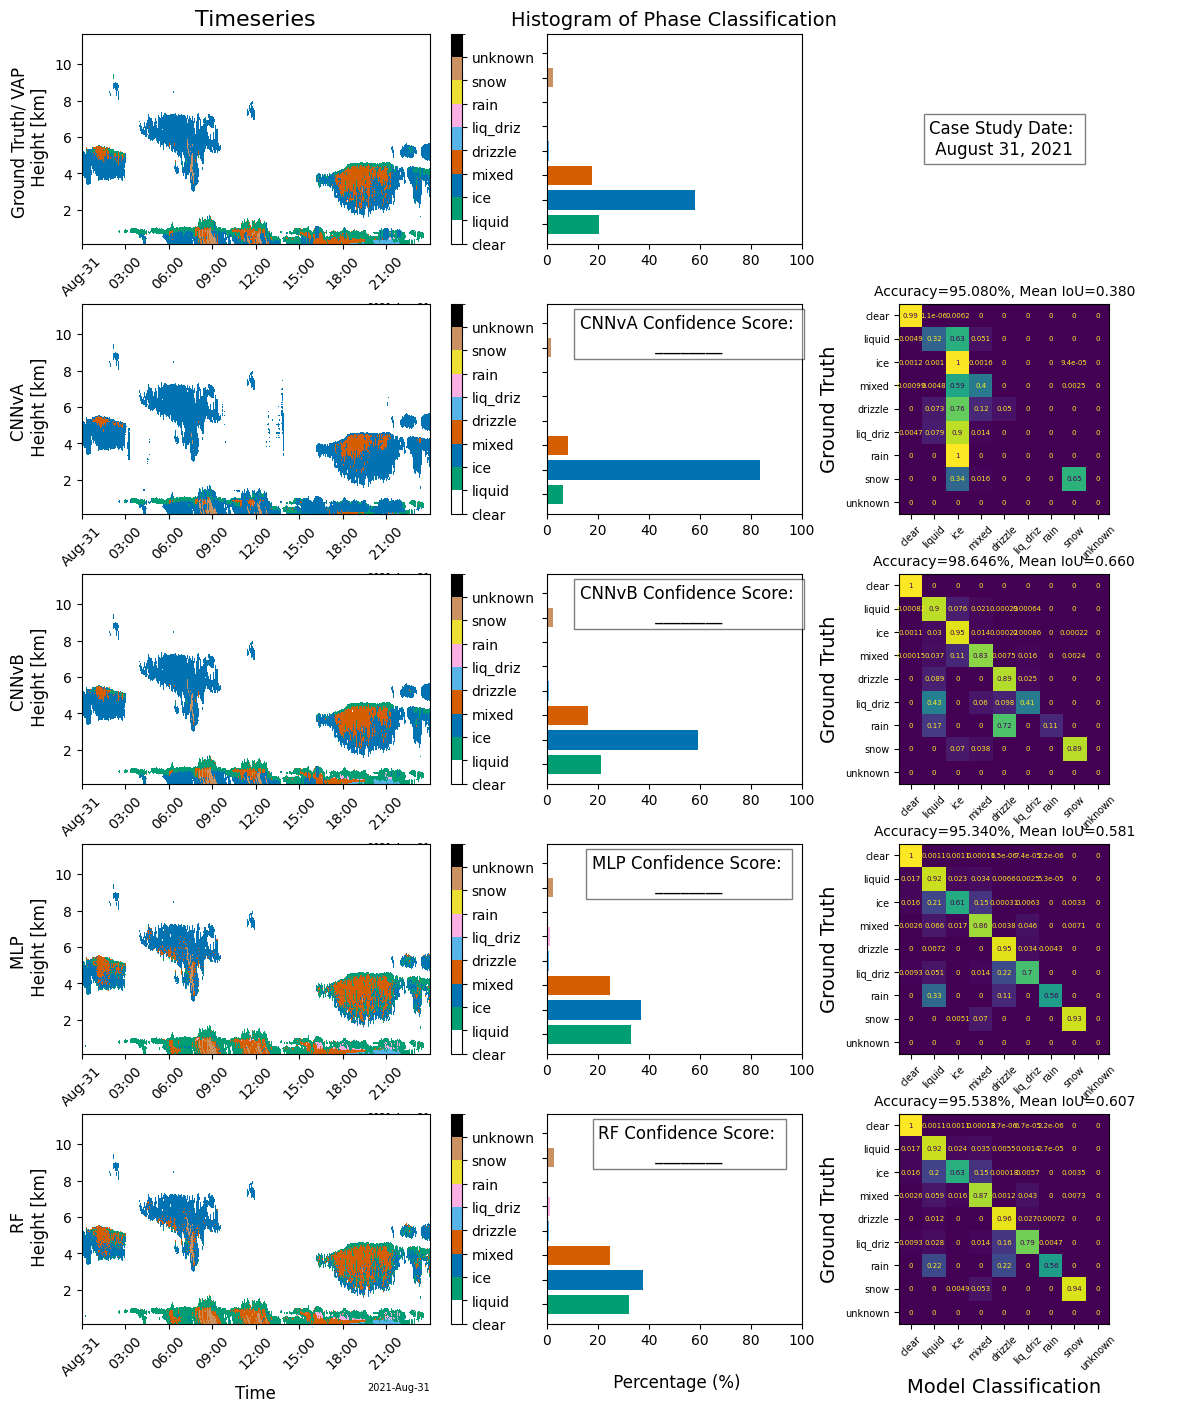

In [72]:
# Create some example data
data = [np.random.rand(10) for _ in range(12)]

# Create a figure
fig = plt.figure(figsize=(15, 15))

# Define the positions for each subplot
# The positions are defined as [left, bottom, width, height]
heights = 0.18
width = 0.23
hist_pos = 0.36
matrix_pos = 0.55
height = 0.14
positions = [
    # Row 1 Ground Truth
    [0.05, 0.05 +  heights * 4, width + 0.06, height],  # Subplot 1
    [hist_pos, 0.05 +  heights * 4, width - 0.06, height],  # Subplot 2
    [matrix_pos, 0.05 +  heights * 4, width, height],  # Subplot 3
    # Row 2 CNNv1
    [0.05, 0.05 +  heights * 3, width + 0.06, height],   # Subplot 4
    [hist_pos, 0.05 +  heights * 3, width - 0.06, height],   # Subplot 5
    [matrix_pos, 0.05 +  heights * 3, width, height],   # Subplot 6
    # Row 3 CNNv2
    [0.05, 0.05 +  heights * 2, width + 0.06, height],  # Subplot 7
    [hist_pos, 0.05 +  heights * 2, width - 0.06, height],  # Subplot 8
    [matrix_pos, 0.05 +  heights * 2, width, height],  # Subplot 9
    # Row 4 MLP
    [0.05, 0.05 +  heights * 1, width + 0.06, height],   # Subplot 10
    [hist_pos, 0.05 +  heights * 1, width - 0.06, height],   # Subplot 11
    [matrix_pos, 0.05 +  heights * 1, width, height],   # Subplot 12
    # Row 5 RF
    [0.05, 0.05, width + 0.06, height],  # Subplot 13
    [hist_pos, 0.05, width - 0.06, height],  # Subplot 14
    [matrix_pos, 0.05, width, height],  # Subplot 15
    # Text Boxes
    [0.33, 0.12 +  heights * 3, 0.25, 0.1],  # Text Box
    [0.33, 0.12 +  heights * 2, 0.25, 0.1],  # Text Box
    [0.33, 0.12 +  heights * 1, 0.25, 0.1],  # Text Box
    [0.33, 0.12 +  heights * 0, 0.25, 0.1],  # Text Box
    # Additional positions can be added for more subplots if needed
]

# Create subplots
axs = []
for pos in positions:
    ax = fig.add_axes(pos)  # Create an axes at the specified position
    axs.append(ax)

# Plotting example data in the subplots
create_timeseries('cloud_phase_mplgr',axs[0], ds, PHASE_MAP, custom_colors)
create_histogram('cloud_phase_mplgr',axs[1], ds, PHASE_MAP, custom_colors)
#
create_timeseries('cnn_20240429_213223',axs[3], ds, PHASE_MAP, custom_colors)
create_histogram('cnn_20240429_213223',axs[4], ds, PHASE_MAP, custom_colors)
create_matrix('cnn_20240429_213223',axs[5], ds, PHASE_MAP)
#
create_timeseries('cnn_20240501_090456',axs[6], ds, PHASE_MAP, custom_colors)
create_histogram('cnn_20240501_090456',axs[7], ds, PHASE_MAP, custom_colors)
create_matrix('cnn_20240501_090456',axs[8], ds, PHASE_MAP)
#
create_timeseries('mlp_1600k_20240514_052837',axs[9], ds, PHASE_MAP, custom_colors)
create_histogram('mlp_1600k_20240514_052837',axs[10], ds, PHASE_MAP, custom_colors)
create_matrix('mlp_1600k_20240514_052837',axs[11], ds, PHASE_MAP)
#
create_timeseries('rf_1600k_20240514_033147',axs[12], ds, PHASE_MAP, custom_colors)
create_histogram('rf_1600k_20240514_033147',axs[13], ds, PHASE_MAP, custom_colors)
create_matrix('rf_1600k_20240514_033147',axs[14], ds, PHASE_MAP)

# Add a text box in the designated position
textstr = 'Case Study Date: \n August 31, 2021 '
axs[2].text(0.5, 0.5, textstr, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
axs[2].set_axis_off()  # Hide axes for the text box


# Add a text box in the designated position
textstr = 'CNNvA Confidence Score: \n ________ '
axs[15].text(0.5, 0.5, textstr, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
axs[15].set_axis_off()  # Hide axes for the text box

textstr = 'CNNvB Confidence Score: \n ________ '
axs[16].text(0.5, 0.5, textstr, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
axs[16].set_axis_off()  # Hide axes for the text box

textstr = 'MLP Confidence Score: \n ________ '
axs[17].text(0.5, 0.5, textstr, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
axs[17].set_axis_off()  # Hide axes for the text box

textstr = 'RF Confidence Score: \n ________ '
axs[18].text(0.5, 0.5, textstr, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
axs[18].set_axis_off()  # Hide axes for the text box

# Adjust layout to prevent clipping
plt.show()


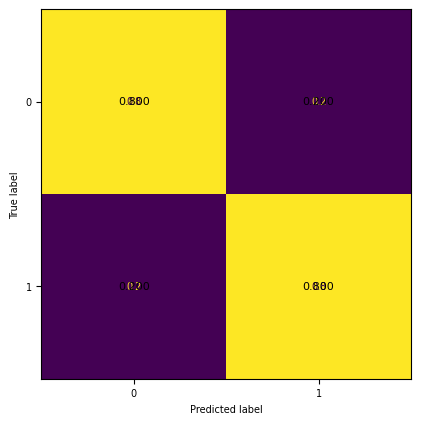

In [68]:
# Sample data
y_true = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
y_pred = [0, 1, 0, 1, 1, 0, 0, 1, 0, 1]
labels = [0, 1]

# Create confusion matrix display
fig, axs = plt.subplots()

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    labels=labels,
    ax=axs,
    colorbar=False,
    normalize="true"
)

# Modify the annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        value = cm_display.confusion_matrix[i, j]
        if value < 0.001:
            axs.text(j, i, "", ha='center', va='center', fontsize=8)  # Remove small values
        else:
            axs.text(j, i, f'{value:.3f}', ha='center', va='center', fontsize=8)  # Adjust font size

plt.show()